## Goal
- To use Time-Series to predict future average monthly temperatures in Nairobi, Kenya
### Executive Summary:
- Using Data Science pipeline we have concluded the best model to use for predicting future temperatures is using previous cycle

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sweetviz as sv
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

# Acquire

In [2]:
df = pd.read_csv('Global.csv')
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             239177 non-null  object 
 1   AverageTemperature             228175 non-null  float64
 2   AverageTemperatureUncertainty  228175 non-null  float64
 3   City                           239177 non-null  object 
 4   Country                        239177 non-null  object 
 5   Latitude                       239177 non-null  object 
 6   Longitude                      239177 non-null  object 
dtypes: float64(2), object(5)
memory usage: 12.8+ MB


### Takeaways:
- 239k entries 
- Average monthly temperature of cities around the world
- Measurements are in Celsius

# Prepare

In [4]:
# format the date time
df.dt = pd.to_datetime(df.dt, format='%Y-%m-%d')


In [5]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [6]:
# Rename columns; dt to date and AverageTemerature as temp
df = df.rename(columns={'dt': 'date', 'AverageTemperature': 'temp'})


In [7]:
# Since I have oicked up Niarobi, Kenya, look for Niarobi in the dataset
df = df[df['City'].str.match('Nairobi')]


In [8]:
# Checking for missing values
df.isnull().sum()

date                               0
temp                             287
AverageTemperatureUncertainty    287
City                               0
Country                            0
Latitude                           0
Longitude                          0
dtype: int64

In [9]:
# Set the date as an index to be used in time-series analysis
df = df.set_index('date').sort_index()
df.head()

,temp,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
date,,,,,,
1850-01-01,15.759,1.496,Nairobi,Kenya,0.80S,36.16E
1850-02-01,17.145,1.496,Nairobi,Kenya,0.80S,36.16E
1850-03-01,16.988,2.248,Nairobi,Kenya,0.80S,36.16E
1850-04-01,15.844,1.597,Nairobi,Kenya,0.80S,36.16E
1850-05-01,14.686,0.998,Nairobi,Kenya,0.80S,36.16E


In [10]:
# Check for the oldest(first) entry and the latest(last) entry
df.index.min(), df.index.max()

(Timestamp('1850-01-01 00:00:00'), Timestamp('2013-09-01 00:00:00'))

In [11]:
# Check if the index values are unique
df.shape[0], df.index.nunique()


(1965, 1965)

<AxesSubplot:xlabel='date'>

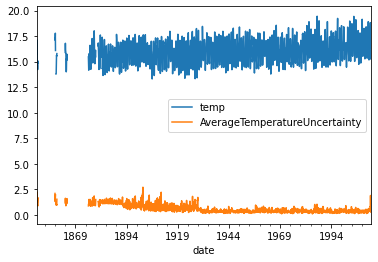

In [12]:
# Generic plot to see what the plots look like
df.plot()

In [13]:
# Check what the value counts look like 
df['City'].value_counts()

Nairobi    1965
Name: City, dtype: int64

In [14]:
df.head()

,temp,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
date,,,,,,
1850-01-01,15.759,1.496,Nairobi,Kenya,0.80S,36.16E
1850-02-01,17.145,1.496,Nairobi,Kenya,0.80S,36.16E
1850-03-01,16.988,2.248,Nairobi,Kenya,0.80S,36.16E
1850-04-01,15.844,1.597,Nairobi,Kenya,0.80S,36.16E
1850-05-01,14.686,0.998,Nairobi,Kenya,0.80S,36.16E


In [15]:
# since just one city was picked, Country, Latitude, Longitude werendropped. and the AverageTemperatureUncertainty is 
# an error in the data collection method and unncessary, so it was dropped
df = df.drop(columns = ['Country', 'City', 'Latitude', 'Longitude', 'AverageTemperatureUncertainty'])

In [16]:
# check the last entry
df.tail(5)

,temp
date,
2013-05-01,16.967
2013-06-01,15.476
2013-07-01,15.240
2013-08-01,15.985
2013-09-01,NaN


In [17]:
# check for missing values
df['temp'].isnull().value_counts()

False    1678
True      287
Name: temp, dtype: int64

<AxesSubplot:xlabel='date'>

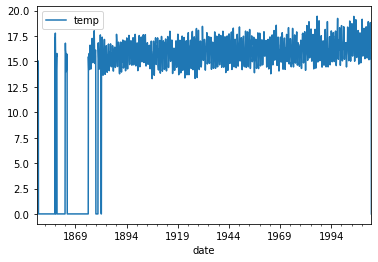

In [18]:
# Generic plot to see what the data looks like
by_month = df.groupby(['date']).temp.sum().reset_index()
by_month.plot(x='date', y='temp')


In [19]:
# To get rid of the missing values, the data from befor 1884 and data for 2013-09-01 was dropped 
df = df[~(df.index < '1884-01-01') & (df.index != '2013-09-01')]

In [20]:
# check for data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1556 entries, 1884-01-01 to 2013-08-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    1556 non-null   float64
dtypes: float64(1)
memory usage: 24.3 KB


In [21]:
# basic statistical analysis 
df.describe()

,temp
count,1556.000000
mean,16.118561
std,1.051031
min,13.304000
25%,15.423750
50%,16.127000
75%,16.839000
max,19.446000


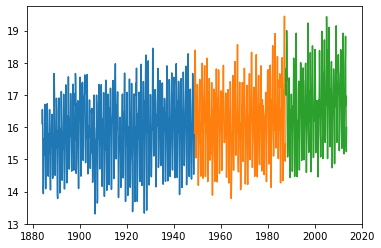

In [22]:
# Train, valdidate and test split to include the end of the data as test set
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

plt.plot(train.index, train.temp)
plt.plot(validate.index, validate.temp)
plt.plot(test.index, test.temp)


### Takeaways:
- Just the City of Nairobi, Kenya was picked
- To drop missing values, all the data before 1884 was dropped
- Latitude, Longitude, City and Country was single value data sets and were dropped
- 2013-09-01 also had a missing value and dropped

# Explore

In [23]:
# Check what train looks like
y = train.temp
y.head(2)

date
1884-01-01    16.111
1884-02-01    16.545
Name: temp, dtype: float64

<AxesSubplot:ylabel='Frequency'>

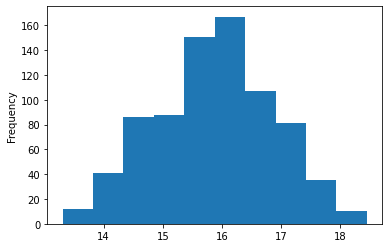

In [24]:
# Histogram plot of the temprature 
y.plot.hist()

[Text(0.5, 1.0, 'Average Temperature by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Temp (C)')]

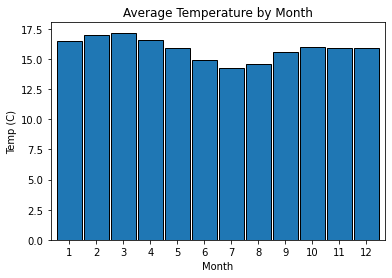

In [25]:
# plot of the monthly average temperature
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='Month', ylabel='Temp (C)')


<AxesSubplot:title={'center':'Monthly average'}, xlabel='date'>

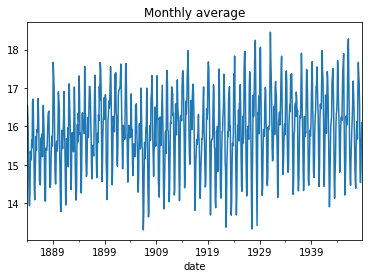

In [26]:
# plot of the average monthly temperature
y.resample('M').mean().plot(title='Monthly average')


<AxesSubplot:title={'center':'Yearly average'}, xlabel='date'>

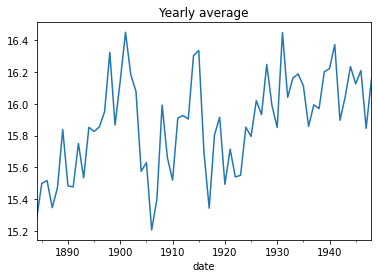

In [27]:
# plot of the average yearly temperature
y.resample('Y').mean().plot(title='Yearly average')


<AxesSubplot:title={'center':'Average year-to-year change in temperature'}, xlabel='date'>

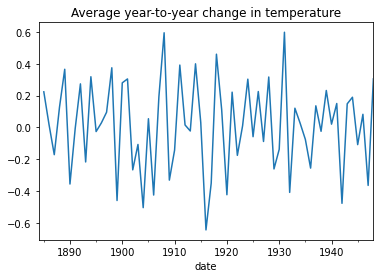

In [28]:
# average variation on tempreture
y.resample('Y').mean().diff().plot(title='Average year-to-year change in temperature')

<AxesSubplot:title={'center':'Average 5 Years change in temperature'}, xlabel='date'>

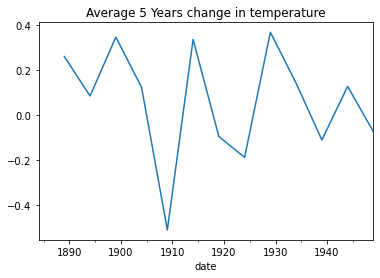

In [29]:
# Average 5 years variation 
y.resample('5Y').mean().diff().plot(title='Average 5 Years change in temperature')

<AxesSubplot:title={'center':'Average Ten Years change in temperature'}, xlabel='date'>

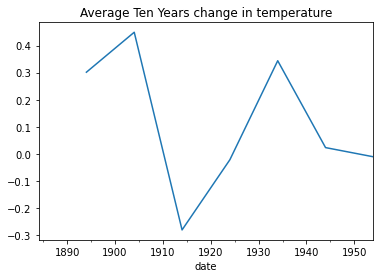

In [30]:
# average 10 years variation
y.resample('10Y').mean().diff().plot(title='Average Ten Years change in temperature')

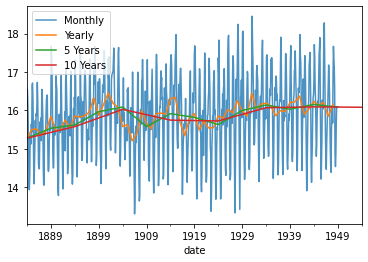

In [31]:
# plot of the average monthly, yearly, 5 years and 10 years temperatures 
y.resample('M').mean().plot(alpha=.8, label='Monthly')
y.resample('Y').mean().plot(label='Yearly')
y.resample('5Y').mean().plot(label='5 Years')
y.resample('10Y').mean().plot(label='10 Years')
plt.legend()

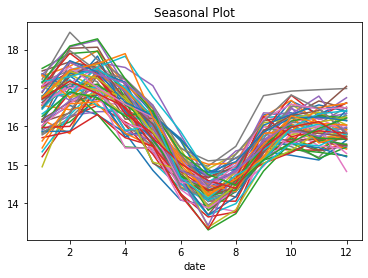

In [32]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot').get_legend().remove()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

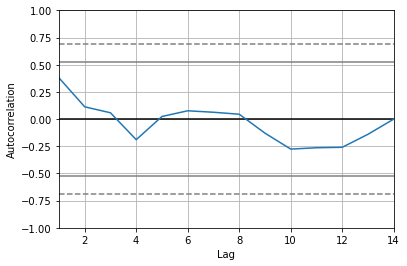

In [33]:
pd.plotting.autocorrelation_plot(train.temp.resample('5Y').mean())


In [34]:
y = train.temp.resample('Y').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()


,y,trend,seasonal,resid
date,,,,
1884-12-31,15.275417,15.275417,0.0,0.0
1885-12-31,15.499167,15.499167,0.0,0.0
1886-12-31,15.516833,15.516833,0.0,0.0
1887-12-31,15.345917,15.345917,0.0,0.0
1888-12-31,15.473167,15.473167,0.0,0.0


<AxesSubplot:xlabel='date'>

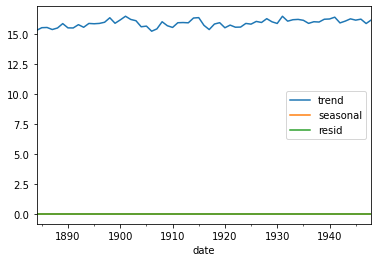

In [35]:
decomposition.iloc[:, 1:].plot()


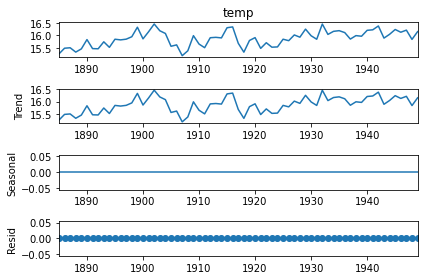

In [36]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None


In [37]:
# check what the df looks like
train, validate, test

(              temp
 date              
 1884-01-01  16.111
 1884-02-01  16.545
 1884-03-01  16.299
 1884-04-01  15.827
 1884-05-01  14.855
 ...            ...
 1948-06-01  14.853
 1948-07-01  14.536
 1948-08-01  14.815
 1948-09-01  15.609
 1948-10-01  16.095
 
 [778 rows x 1 columns],
               temp
 date              
 1948-11-01  15.810
 1948-12-01  15.848
 1949-01-01  16.600
 1949-02-01  17.074
 1949-03-01  18.393
 ...            ...
 1987-04-01  18.087
 1987-05-01  16.820
 1987-06-01  15.360
 1987-07-01  14.944
 1987-08-01  15.469
 
 [466 rows x 1 columns],
               temp
 date              
 1987-09-01  17.135
 1987-10-01  17.809
 1987-11-01  16.997
 1987-12-01  17.629
 1988-01-01  17.454
 ...            ...
 2013-04-01  16.674
 2013-05-01  16.967
 2013-06-01  15.476
 2013-07-01  15.240
 2013-08-01  15.985
 
 [312 rows x 1 columns])

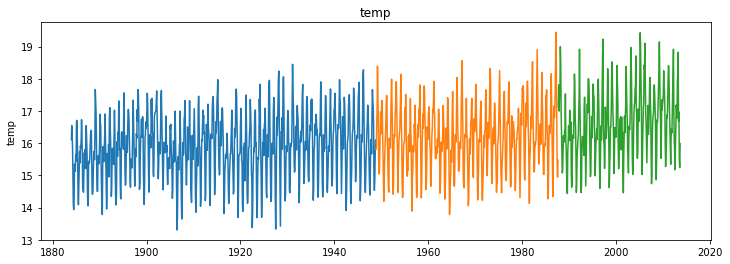

In [38]:
# plot the train, validate and test
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()


In [39]:
train.head()

,temp
date,
1884-01-01,16.111
1884-02-01,16.545
1884-03-01,16.299
1884-04-01,15.827
1884-05-01,14.855


### Takeaways:
- Temperature ranges from 13C to 19C
- The warmest months are February and March
- The coldest months are July and August

# Model

In [40]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 6)
    return rmse


In [41]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()


In [42]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


## Model using Last Observed Value

In [43]:
# set the last observed value as predicted value
temp = round(train['temp'][-1:][0], 2)


yhat_df = pd.DataFrame({'temp': [temp]}, 
                       index = validate.index)

yhat_df.head(2)


,temp
date,
1948-11-01,16.1
1948-12-01,16.1


temp -- RMSE: 1


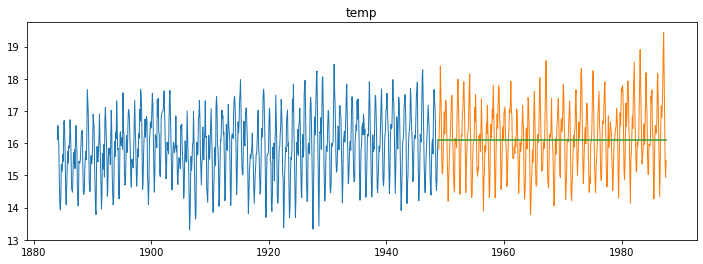

In [44]:
# plot the predicted value on validate
plot_and_eval(col)

In [45]:
# this function appends the model type and RMSE values
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)


### Takeaways:
- It doesnot take to account the highs and lows of tempreture

## Model using Average Temperature

In [46]:
temp = round(train['temp'].mean(), 2)

yhat_df = pd.DataFrame({'temp': [temp]
                           }, index = validate.index)
yhat_df.head(3)

,temp
date,
1948-11-01,15.88
1948-12-01,15.88
1949-01-01,15.88


temp -- RMSE: 1


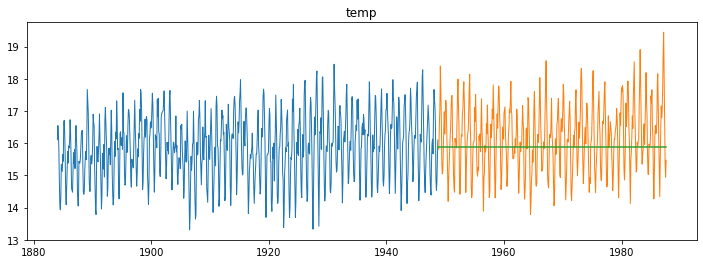

In [47]:
plot_and_eval(col)

In [48]:
# this function appends the model type and RMSE values
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Simple Average', 
                             target_var = col)


### Takeaways:
- It doesnot take to account the highs and lows of tempreture

## Model using Rolling(yearly) Average

In [49]:
# Compute one year rolling average
period = 12

items = round(train['temp'].rolling(period).mean().iloc[-1], 2)


# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'temp': [items]
                           }, index = validate.index)
yhat_df.head(2)


,temp
date,
1948-11-01,16.11
1948-12-01,16.11


temp -- RMSE: 1


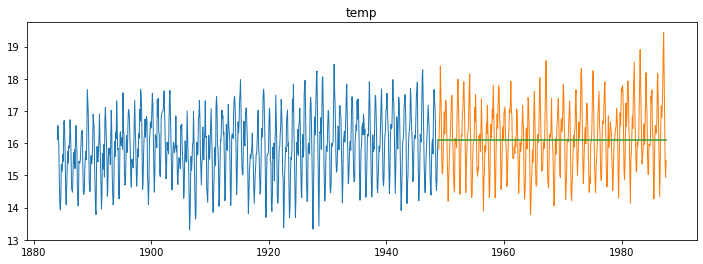

In [50]:
# this function appends the model type and RMSE values
for col in train.columns:
    plot_and_eval(col)
    eval_df = append_eval_df(model_type = 'Rolling Average', target_var = col)


In [51]:
# evaluate RMSE
evaluate(col)

1.011603

In [52]:
periods = [12, 24, 60, 120]

for p in periods:
    temp = round(train['temp'].rolling(p).mean().iloc[-1], 2)
    
    yhat_df = pd.DataFrame({'temp': [temp]}, index = validate.index)

    model_type = str(p) + 'm moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'temp')

### Takeaways:
- It doesnot take to account the highs and lows of tempreture

## Model using Holt's 

In [53]:
# make the Holt's model
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)
    
yhat_df


,temp
date,
1948-11-01,15.81
1948-12-01,15.79
1949-01-01,15.78
1949-02-01,15.77
1949-03-01,15.75
...,...
1987-04-01,9.27
1987-05-01,9.26
1987-06-01,9.24


temp -- RMSE: 4


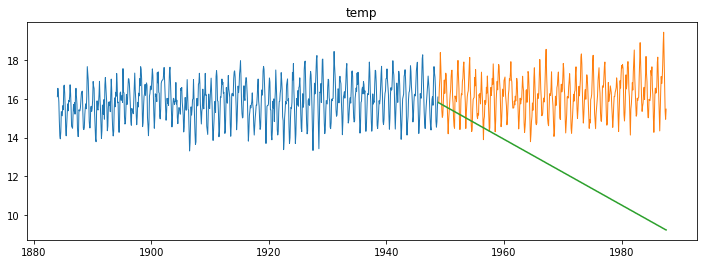

In [54]:
# this function appends the model type and RMSE values
for col in train.columns:
    plot_and_eval(col)
    eval_df = append_eval_df(model_type = 'Holts', target_var = col)

### Takeaways:
- It doesnot take to account the highs and lows of tempreture
- It also seems to drift away as time progresses


## Model using the previous year

In [55]:
# resplit the data as <= 2010 as train, 2011 as predict and 2012 as test
train = df[:'2010']
validate = df['2011']
test = df['2012']
train

,temp
date,
1884-01-01,16.111
1884-02-01,16.545
1884-03-01,16.299
1884-04-01,15.827
1884-05-01,14.855
...,...
2010-08-01,15.697
2010-09-01,16.000
2010-10-01,16.871


In [56]:
# validate 
yhat_df = train['2010'] + train.diff(365).mean()

In [57]:
pd.concat([yhat_df.head(1), validate.head(1)])


,temp
date,
2010-01-01,17.732235
2011-01-01,17.768000


temp -- RMSE: 0


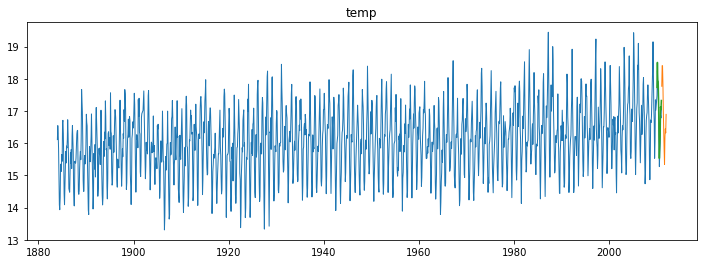

In [58]:
# this function appends the model type and RMSE values
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

In [59]:
# RMSE for validate
evaluate(col)

0.409258

In [60]:
# Dataframe of all the models used and thier RMSE values
eval_df

,model_type,target_var,rmse
0,last_observed_value,temp,1.012335
1,Simple Average,temp,1.052625
2,Rolling Average,temp,1.011603
3,12m moving average,temp,1.011603
4,24m moving average,temp,1.026801
5,60m moving average,temp,1.010969
6,120m moving average,temp,1.010434
7,Holts,temp,4.301564
8,previous year,temp,0.409258


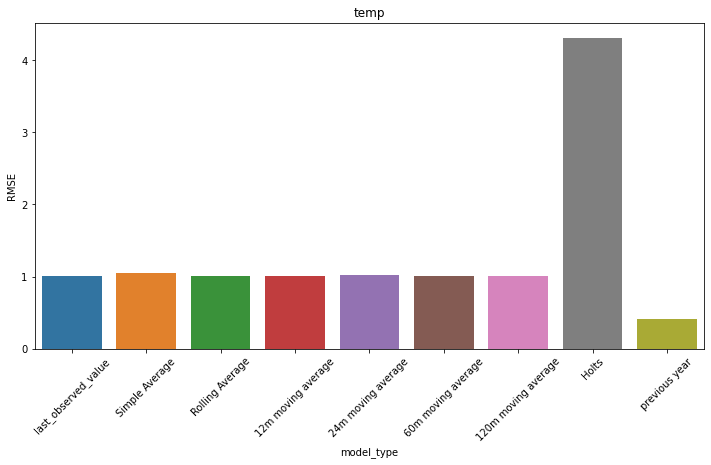

In [61]:
# plot the models vs their RMSE 
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()


In [62]:
# Plot and evaluate train, validate, and test
def plot_and_eval_test(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5, color="red")
    plt.title(target_var)
    plt.legend()
    plt.show()


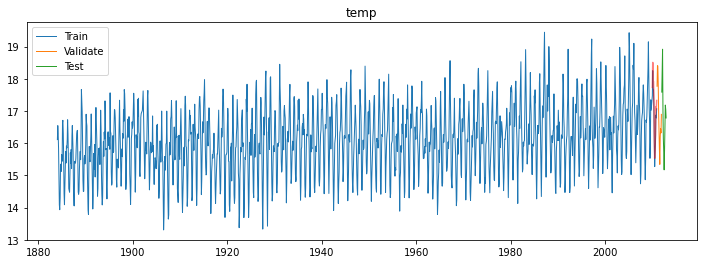

In [63]:
# plot of train, validate and test
for col in train.columns:
    plot_and_eval_test(col)

In [64]:
# RMSE for test 
rmse = round(sqrt(mean_squared_error(test['temp'], yhat_df['temp'])), 6)
rmse

0.583361

# Conclusion

- Other than the model that uses the previous cycle, all the others performed poorly
- I would pick the model that uses the previous cycle which has an RMSE of 0.409258 on validate and 0.583361 on test for my predictions